In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [ ]:
class Dense:
    def __init__(self, units, input_size, activation, name):
        self.W = tf.Variable(tf.random.normal([units, input_size]) * tf.math.sqrt(1/input_size), name=(name + '_W'))
        self.b = tf.Variable(tf.zeros([units,1]), name=(name + '_b'))
        self.activation = activation

    def forward(self, X, training):
        Z = tf.linalg.matmul(self.W,X) + self.b
        A = self.activation(Z)
        return A

    def get_vars(self):
        return [self.W, self.b]

    def get_weigths(self):
        return [self.W]

In [5]:
class Batch_norm:
    def __init__(self, units, input_size, activation, name):
        self.W = tf.Variable(tf.random.normal([units, input_size]) * tf.math.sqrt(1/input_size), name=(name + '_W')) 
        self.activation = activation

        self.gamma = tf.Variable(tf.ones([units, 1]), name=(name + '_gamma'))
        self.beta = tf.Variable(tf.ones([units, 1]), name=(name + '_beta'))
        self.mu_test = tf.Variable(tf.zeros([units,1]))
        self.sigma_test = tf.Variable(tf.ones([units,1]))

    def forward(self, X, training):
        e = 10**-8

        Z = tf.linalg.matmul(self.W,X)

        if training:
            mu = tf.math.reduce_mean(Z, axis=1, keepdims=True)
            sigma = tf.math.reduce_variance(Z - mu, axis=1, keepdims=True)
            sigma = tf.math.sqrt(sigma + e)

            self.mu_test.assign(0.95*self.mu_test + 0.05*mu)
            self.sigma_test.assign(0.95*self.sigma_test + 0.05*sigma)
        else:
            mu = self.mu_test
            sigma = self.sigma_test

        Z = (Z - mu) / sigma
        Z = self.gamma * Z + self.beta

        A = self.activation(Z)
        return A

    def get_vars(self):
        return [self.W, self.gamma, self.beta]

    def get_weigths(self):
        return [self.W]

In [6]:
class Dropout:
    def __init__(self, keep_prob):
        self.keep_prob = keep_prob

    def forward(self, X, training):
        if not training:
            return X
        X = tf.nn.dropout(X, 1-self.keep_prob)
        # D = tf.random.uniform(tf.shape(X)) < self.keep_prob
        # D = tf.cast(D, dtype=tf.float32)
        # X = X * D
        # X = X / self.keep_prob
        return X

    def get_vars(self):
        return None

    def get_weigths(self):
        return None

In [7]:
class Softmax:
    def __init__(self, classes, input_size, name):
        self.classes = classes

        self.W = tf.Variable(tf.random.normal([classes, input_size]) * tf.math.sqrt(1/input_size), name=(name + '_W'))
        self.b = tf.Variable(tf.zeros([classes,1]), name=(name + '_b'))

    def forward(self, X, training):
        Z = tf.linalg.matmul(self.W,X) + self.b

        T = tf.math.exp(Z)
        A = T / tf.math.reduce_sum(T, axis=0)
        return A

    def get_vars(self):
        return [self.W, self.b]

    def get_weigths(self):
        return [self.W]

In [8]:
class Model:
    def __init__(self, layer_names, units, input_size, cost_function, name="model"):
        self.layers = self.__create_layers__(layer_names, units, input_size)
        self.cost = cost_function
        self.input_size = input_size
        self.name = name

    @tf.function
    def forward(self, X, training=False, testing=False):
        for layer in self.layers:
            X = layer.forward(X, training)
            if testing:
                tf.print(X)
        return X
    
    def train(self, train_ds, dev_ds, optimizer, weights_regularization=None):
        #training
        self.variables = self.__get_variables__()
        numerator = 0.
        denominator = 0.
        for X, Y in train_ds: 
            cost = self.__training_step__(X, Y, optimizer)
            m = tf.shape(X)[1]
            m = tf.cast(m, tf.float32)
            numerator = numerator + cost * m
            denominator = denominator + m
        cost_train = numerator / denominator

        #validation
        numerator = 0.
        denominator = 0.
        for X, Y in dev_ds:
            prediction = self.forward(X, training=False)
            cost = self.cost(Y, prediction) 
            m = tf.shape(X)[1]
            m = tf.cast(m, tf.float32)
            numerator = numerator + cost * m
            denominator = denominator + m
        cost_dev = numerator / denominator

        return cost_train, cost_dev

    @tf.function
    def __training_step__(self, X_train, Y_train, optimizer):
        print('Traceing...')
        with tf.GradientTape() as tape:           
            prediction = self.forward(X_train, training=True)
            cost = self.cost(Y_train, prediction)
            grads = tape.gradient(cost, self.variables)
   
        optimizer.apply_gradients(grads, self.variables)

        return cost

    def __get_weights__(self):
        weights = []
        for layer in self.layers:
            weights = layer.get_weights()
            if weights != None:
                weights += (weights)
        return weights
        
    def __get_variables__(self):
        variables = []
        for layer in self.layers:
            var = layer.get_vars()
            if var != None:
                variables += var
        return variables

    def __create_layers__(self, layer_names, units, input_size):
        units.insert(0, input_size)
        layers = []
        i = 1

        for layer_name in layer_names:
            if layer_name == 'dense':
                layer = Dense(units[i], units[i-1], tf.nn.relu, 'Dense' + str(i))
                layers.append(layer)
                i += 1

            elif layer_name == 'batch_norm':
                layer = Batch_norm(units[i], units[i-1], tf.nn.relu, 'Batch_norm' + str(i))
                layers.append(layer)
                i += 1

            elif layer_name == 'dropout':
                layer = Dropout(keep_prob)
                layers.append(layer)

            elif layer_name == 'softmax':  
                layer = Softmax(units[i], units[i-1], 'Dense' + str(i))
                layers.append(layer)
                i += 1

        return layers 

In [9]:
class Adam:
    def __init__(self, learning_rate, beta_v = 0.9, beta_s = 0.999):
        self.v = []
        self.s = []
        self.iteration = 0
        self.learning_rate = learning_rate
        self.beta_v = beta_v
        self.beta_s = beta_s

    def apply_gradients(self, grads, variables):
        self.iteration += 1

        for i in range(len(grads)):
            if len(self.v) <= i:
                self.v.append(tf.Variable(tf.zeros(tf.shape(grads[i]))))
            if len(self.s) <= i:
                self.s.append(tf.Variable(tf.zeros(tf.shape(grads[i]))))

            self.v[i].assign(self.beta_v*self.v[i] + (1-self.beta_v)*grads[i])
            v_corrected = self.v[i] / (1 - tf.math.pow(self.beta_v,self.iteration))

            self.s[i].assign(self.beta_s*self.s[i] + (1-self.beta_s)* tf.math.square(grads[i]))
            s_corrected = self.s[i] / (1 - tf.math.pow(self.beta_s,self.iteration))

            change = self.learning_rate * (v_corrected/(tf.math.sqrt(s_corrected) + 10**-8))

            variables[i].assign_add(-change)

In [153]:
def Loss(Y, A):
    loss = tf.math.log(A + 10**-8)
    loss = Y * loss
    loss = -tf.math.reduce_sum(loss, axis=1)
    return loss

In [154]:
def Cost(Y, A):
    losses = Loss(Y, A)
    cost = tf.reduce_mean(losses)
    return cost

In [155]:
def get_training_data(batch_size):
    (x_train, y_train), (x_dev, y_dev) = tf.keras.datasets.mnist.load_data()
    
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_ds = train_ds.map(lambda x,y: (tf.reshape(x,[-1])/255, tf.one_hot(y,10)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_ds = train_ds.batch(batch_size)
    #train_ds = train_ds.map(lambda x,y: (tf.linalg.matrix_transpose(x), tf.linalg.matrix_transpose(y)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_ds = train_ds.cache()
    train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

    dev_ds = tf.data.Dataset.from_tensor_slices((x_dev, y_dev))
    dev_ds = dev_ds.map(lambda x,y: (tf.reshape(x,[-1])/255, tf.one_hot(y,10)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dev_ds = dev_ds.batch(batch_size)
    #dev_ds = dev_ds.map(lambda x,y: (tf.linalg.matrix_transpose(x), tf.linalg.matrix_transpose(y)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dev_ds = dev_ds.cache()
    dev_ds = dev_ds.prefetch(tf.data.experimental.AUTOTUNE)

    return train_ds, dev_ds

In [156]:
image_height = 28
image_width = 28

batch_size = 512

train_ds, dev_ds = get_training_data(batch_size)

In [62]:
layer_names = [
    ['dense', 'dense', 'dense', 'softmax'],
    ['dense', 'dense', 'softmax']]
#layer_names = [['batch_norm', 'batch_norm', 'softmax']]

units = [
    [8,4,4,10],
    [8,4,10]]

names = ['4-layers', '3-layers']

input_size = 784
cost_history = []

learning_rate = 0.001

models = []
for layers, u, name in zip(layer_names, units, names):
    models.append(Model(layers, u[:], input_size, cost_function=Cost, name=name))

#optimizers = [Adam(learning_rate) for _ in range(4)]
optimizers = [Adam(learning_rate) for _ in range(len(layer_names))]
total_epochs = 0

In [63]:
learning_rate = 0.01
for optimizer in optimizers:
    optimizer.learning_rate = learning_rate
epochs = tf.constant(100)

In [64]:
for epoch in range(epochs):
    costs = []
    for model, optimizer in zip(models, optimizers):
        start = tf.timestamp()
        cost_train, cost_dev = model.train(train_ds, dev_ds, optimizer)
        end = tf.timestamp()
        costs.append(cost_train)
        costs.append(cost_dev)
    
    if epoch % 1 == 0:
        print('Epoch {0:4d}: cost_train={1:.7f} cost_dev={2:.7f}, time={3:.5f}'.format(total_epochs, cost_train, cost_dev,end-start))
        #print('Epoch {0:4d}     {1}'.format(total_epochs, end-start))
    total_epochs += 1

    cost_history.append(costs)

Traceing...
Traceing...
Traceing...
Traceing...
Traceing...
Traceing...
Epoch    0: cost_train=1.0551091 cost_dev=0.6711293, time=1.38441
Epoch    1: cost_train=0.6187065 cost_dev=0.5621475, time=0.56715
Epoch    2: cost_train=0.5402356 cost_dev=0.5134304, time=0.58415
Epoch    3: cost_train=0.4970858 cost_dev=0.4861178, time=0.60691
Epoch    4: cost_train=0.4680811 cost_dev=0.4644282, time=0.59441
Epoch    5: cost_train=0.4456128 cost_dev=0.4477145, time=0.58427
Epoch    6: cost_train=0.4291209 cost_dev=0.4362888, time=0.59361
Epoch    7: cost_train=0.4160763 cost_dev=0.4272942, time=0.58418
Epoch    8: cost_train=0.4058122 cost_dev=0.4200482, time=0.58526
Epoch    9: cost_train=0.3971704 cost_dev=0.4138057, time=0.58571
Epoch   10: cost_train=0.3901821 cost_dev=0.4088342, time=0.60163
Epoch   11: cost_train=0.3846501 cost_dev=0.4038687, time=0.60406
Epoch   12: cost_train=0.3798138 cost_dev=0.3998778, time=0.58281
Epoch   13: cost_train=0.3758663 cost_dev=0.3972557, time=0.58105
Epoc

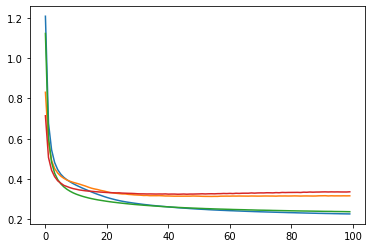

In [99]:
plots = np.asarray(cost_history)
plots = np.transpose(plots)
m = plots.shape[1]
plots = np.reshape(plots, [-1,2,m])
models_names = ['full dense', 'hidden_batch_norm', 'first_dense', 'first_batch_norm']
colors = ['red', 'blue', 'orange', 'gray']
for cost_train, cost_dev, name, color in zip(plots[:,0], plots[:,1], models_names, colors):
    plt.plot(cost_train, color=color, label=name+'-train')
    plt.plot(cost_dev, color=color, label=name+'-dev', linestyle='dashed')
plt.rcParams['figure.figsize'] = [30, 10]
plt.legend()
plt.show()

In [65]:
#calc accuracy
for model in models:
    print(model.name)
    m = 0.
    correct = 0.
    for X,Y in train_ds:
        prediction = model.forward(X)
        prediction = tf.argmax(prediction, axis=0)
        Y = tf.argmax(Y, axis=0)
        temp = prediction == Y
        temp = tf.cast(temp, tf.float32)
        correct += tf.math.reduce_sum(temp)
        m += tf.cast(tf.shape(X)[1], tf.float32)
    tf.print('Train accuracy:',correct/m)

    m = 0.
    correct = 0.
    for X,Y in dev_ds:
        prediction = model.forward(X)
        prediction = tf.argmax(prediction, axis=0)
        Y = tf.argmax(Y, axis=0)
        temp = prediction == Y
        temp = tf.cast(temp, tf.float32)
        correct += tf.math.reduce_sum(temp)
        m += tf.cast(tf.shape(X)[1], tf.float32)
    tf.print('Dev accuracy:',correct/m)
    print('_____')

4-layers
Train accuracy: 0.89705
Dev accuracy: 0.8835
_____
3-layers
Train accuracy: 0.916466653
Dev accuracy: 0.9019
_____


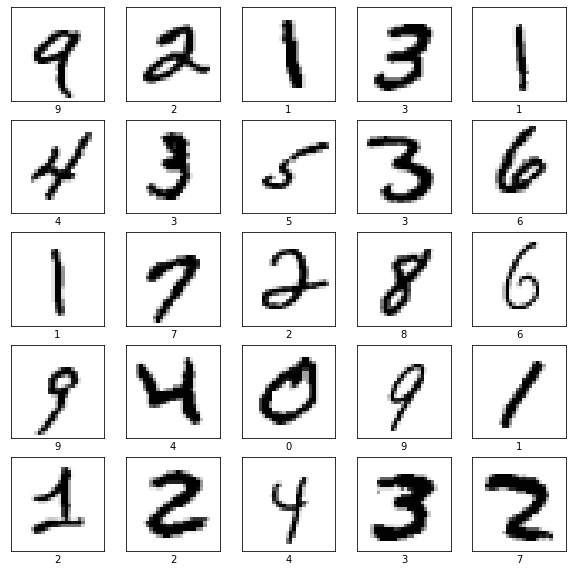

In [66]:
for X, Y in train_ds.take(1):
    prediction = models[0].forward(X)
    prediction = tf.math.argmax(prediction, axis=0)
    ims = tf.reshape(X, [image_height, image_width, -1])

offset = 4

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(ims[:,:,i+offset], cmap='binary')
    plt.xlabel(prediction[i+offset].numpy())
plt.show()

(784, 1)
1


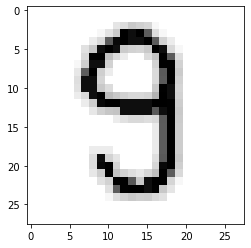

In [184]:
f = tf.io.read_file('test.png')
img = tf.image.decode_png(f)
img = img / 255
img = tf.reshape(img, [image_height * image_width, -1])
print(img.shape)
tf.print(tf.math.reduce_max(img))
plt.imshow(tf.reshape(img,[image_height, image_width]), cmap='binary')
plt.show()

In [185]:
for model in models:
        prediction = model.forward(img)
        tf.print('Prediction:',tf.argmax(prediction, axis=0))
        for i in prediction:
            tf.print(i)
        print('_________')

Prediction: [3]
[1.33832408e-19]
[0.00244542863]
[0.00579735916]
[0.90109688]
[8.55781527e-15]
[0.0178752374]
[7.58541754e-12]
[2.64028927e-07]
[0.0727828145]
[2.09536142e-06]
_________
Prediction: [3]
[2.37456154e-18]
[1.97325094e-13]
[0.0905736685]
[0.508257151]
[4.97393234e-20]
[0.400961727]
[4.76253291e-18]
[1.07373474e-07]
[0.000206982237]
[3.90449e-07]
_________


In [186]:
prediction = network.predict(tf.linalg.matrix_transpose(img))
print(prediction)
tf.print(tf.math.argmax(prediction, axis=1))

[[3.8703372e-12 3.1973975e-17 6.0456078e-03 9.6577871e-01 9.5114836e-20
  2.6798610e-02 2.9870535e-12 4.8697584e-05 1.3276562e-03 7.3034397e-07]]
[3]


In [183]:
for x, y in dev_ds.take(1):
    test_img = x[:,23]

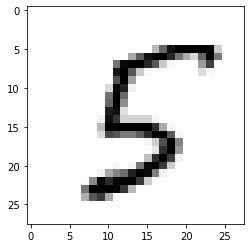

In [94]:
test_img = tf.expand_dims(test_img, axis=1)
plt.imshow(tf.reshape(test_img,[image_height, image_width]), cmap='binary')
plt.show()

In [96]:
prediction = models[0].forward(test_img)
print(prediction)

tf.Tensor(
[[2.8812243e-29]
 [1.6152064e-14]
 [1.2640655e-05]
 [1.3085487e-02]
 [0.0000000e+00]
 [9.8566759e-01]
 [5.8930230e-28]
 [8.7806239e-33]
 [1.2341725e-03]
 [9.7561500e-22]], shape=(10, 1), dtype=float32)


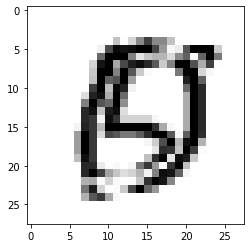

In [97]:
plt.imshow(tf.reshape(tf.math.abs(test_img-img),[image_height,image_width]), cmap='binary')
plt.show()

In [98]:
im = tf.image.convert_image_dtype(tf.reshape(test_img,[image_height,image_width,1]), tf.uint8)
f = tf.image.encode_png(im)
tf.io.write_file('image.png', f)

In [168]:
network = tf.keras.models.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=[784,]),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

network.compile(optimizer='adam',
              loss=Cost, metrics='accuracy')

In [169]:
network.fit(train_ds, epochs=100)

Epoch 1/100
118/118 [==============================] - 0s 2ms/step - loss: 1.9940 - accuracy: 0.2101
Epoch 2/100
118/118 [==============================] - 0s 2ms/step - loss: 1.5274 - accuracy: 0.3854
Epoch 3/100
118/118 [==============================] - 0s 2ms/step - loss: 1.2671 - accuracy: 0.4882
Epoch 4/100
118/118 [==============================] - 0s 2ms/step - loss: 1.1386 - accuracy: 0.5444
Epoch 5/100
118/118 [==============================] - 0s 2ms/step - loss: 1.0536 - accuracy: 0.6004
Epoch 6/100
118/118 [==============================] - 0s 2ms/step - loss: 0.9609 - accuracy: 0.6777
Epoch 7/100
118/118 [==============================] - 0s 2ms/step - loss: 0.8758 - accuracy: 0.7269
Epoch 8/100
118/118 [==============================] - 0s 2ms/step - loss: 0.8060 - accuracy: 0.7467
Epoch 9/100
118/118 [==============================] - 0s 2ms/step - loss: 0.7514 - accuracy: 0.7627
Epoch 10/100
118/118 [==============================] - 0s 2ms/step - loss: 0.7091 - accura